In this notebook, I examine the provided data for Kaggle's Humpback Whale ID challenge. I also look at data augmentations in an attempt to inflate the size of the training dataset.

In [1]:
import math
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image

from tqdm import tqdm

%matplotlib inline

In [56]:
import zipfile as zp

path_to_file='../data/train.zip'
directory_to_extract='../data/train_images'
zip_ref = zp.ZipFile(path_to_file, 'r')
zip_ref.extractall(directory_to_extract)
zip_ref.close()

In [57]:
INPUT_DIR = '../data/train_images/train/'

In [124]:
def plot_images_for_filenames(filenames, labels, rows=4):
    imgs = [plt.imread(INPUT_DIR+filename) for filename in filenames]
    
    return plot_images(imgs, labels, rows)

def plot_images_in_dir(filenames, labels, directory='', rows=4):
    imgs = [plt.imread(directory+'/'+filename) for filename in filenames]
    
    return plot_images(imgs, labels, rows)
    
        
def plot_images(imgs, labels, rows=4):
    # Set figure to 13 inches x 8 inches
    figure = plt.figure(figsize=(13, 8))

    cols = len(imgs) // rows + 1

    for i in range(len(imgs)):
        subplot = figure.add_subplot(rows, cols, i + 1)
        subplot.axis('Off')
        if labels:
            subplot.set_title(labels[i], fontsize=16)
        plt.imshow(imgs[i], cmap='gray')

In [59]:
np.random.seed(42)

## Exploring the dataset

In [60]:
train_df = pd.read_csv('../data/train.csv')
train_df.head(10)

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3
5,0025e8c2.jpg,w_8b1ca89
6,0026a8ab.jpg,w_eaad6a8
7,0031c258.jpg,new_whale
8,0035632e.jpg,w_3d0bc7a
9,0037e7d3.jpg,w_50db782


Let's plot a couple of images at random.

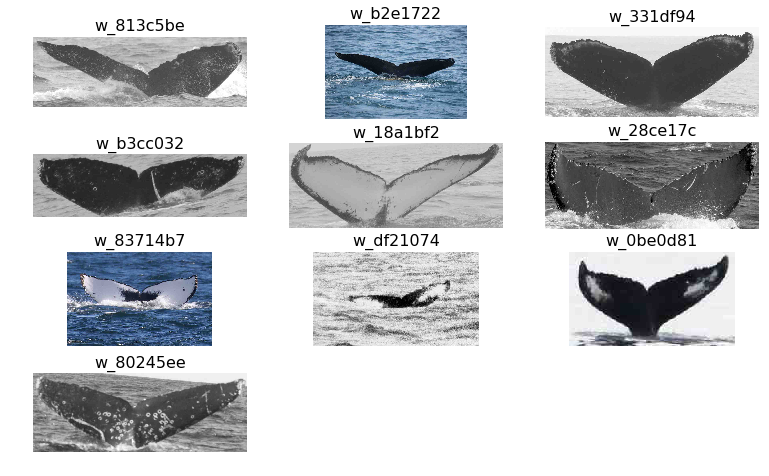

In [70]:
rand_rows = train_df.sample(frac=1.)[:10]
imgs = list(rand_rows['Image'])
labels = list(rand_rows['Id'])

plot_images_for_filenames(imgs, labels)

The competition states that it's hard because: "there are only a few examples for each of 3,000+ whale ids", so let's take a look at the breakdown of number of image per category.

In [74]:
num_categories = len(train_df['Id'].unique())
     
print('Number of categories: '+str(num_categories))

Number of categories: 4251


There appear to be too many categories to graph count by category, so let's instead graph the number of categories by the number of images in the category.

In [75]:
size_buckets = Counter(train_df['Id'].value_counts().values)

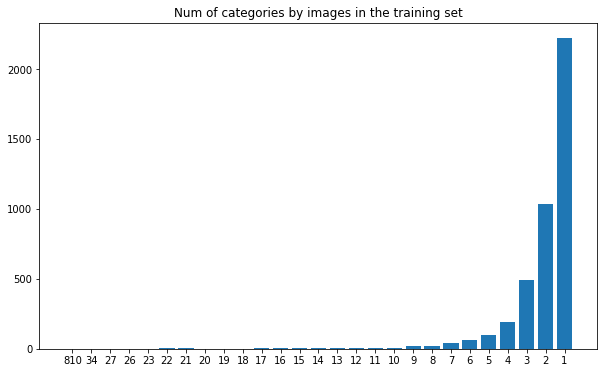

In [76]:
plt.figure(figsize=(10, 6))

plt.bar(range(len(size_buckets)), list(size_buckets.values())[::-1], align='center')
plt.xticks(range(len(size_buckets)), list(size_buckets.keys())[::-1])
plt.title("Num of categories by images in the training set")

plt.show()

As we can see, the vast majority of classes only have a single image in them. This is going to make predictions very difficult for most conventional image classification models.

In [78]:
train_df['Id'].value_counts().head(20)

new_whale    810
w_1287fbc     34
w_98baff9     27
w_7554f44     26
w_1eafe46     23
w_693c9ee     22
w_fd1cb9d     22
w_ab4cae2     22
w_43be268     21
w_73d5489     21
w_987a36f     21
w_f19faeb     20
w_9b401eb     19
w_95874a5     19
w_c0d494d     18
w_b7d5069     18
w_dbda0d6     17
w_0e737d0     17
w_eb0a6ed     17
w_18eee6e     17
Name: Id, dtype: int64

In [81]:
total = len(train_df['Id'])
print('Total images in training set '+str(total))

Total images in training set 9850


New whale is the biggest category with 810, followed by `w_1287fbc`. New whale, I believe, is any whale that isn't in scientist's database. Since we can pick 5 potential labels per id, it's probably going to make sense to always include new_whale in our prediction set, since there's always an 8.2% change that's the right one. Let's take a look at one of the classes, to get a sense what flute looks like from the same whale.

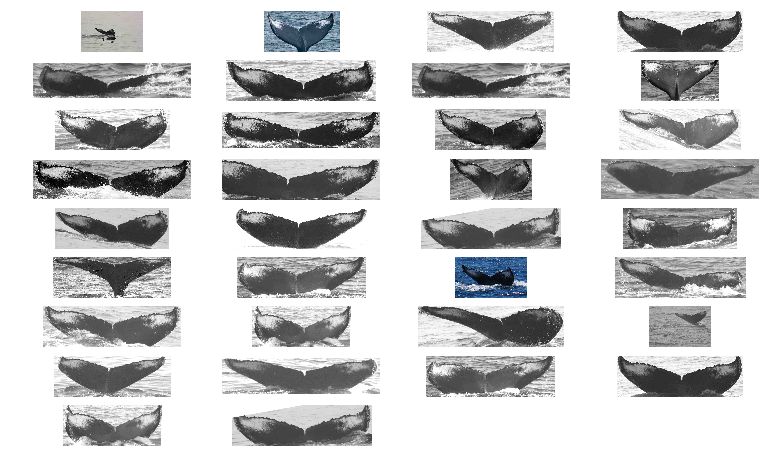

In [82]:
w_1287fbc = train_df[train_df['Id'] == 'w_1287fbc']
plot_images_for_filenames(list(w_1287fbc['Image']), None, rows=9)

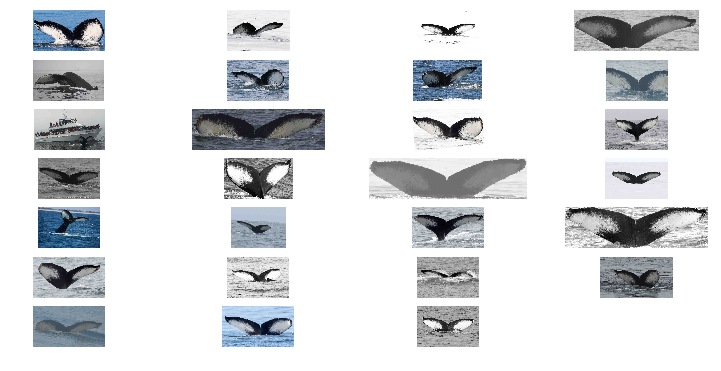

In [83]:
w_98baff9 = train_df[train_df['Id'] == 'w_98baff9']
plot_images_for_filenames(list(w_98baff9['Image']), None, rows=9)

It's very difficult to build a validation set when most classes only have 1 image, so my thinking is to perform some aggressive data augmentation on the classes with < 10 images before creating a train/validation split. Let's take a look at a few examples of whales with only one example.

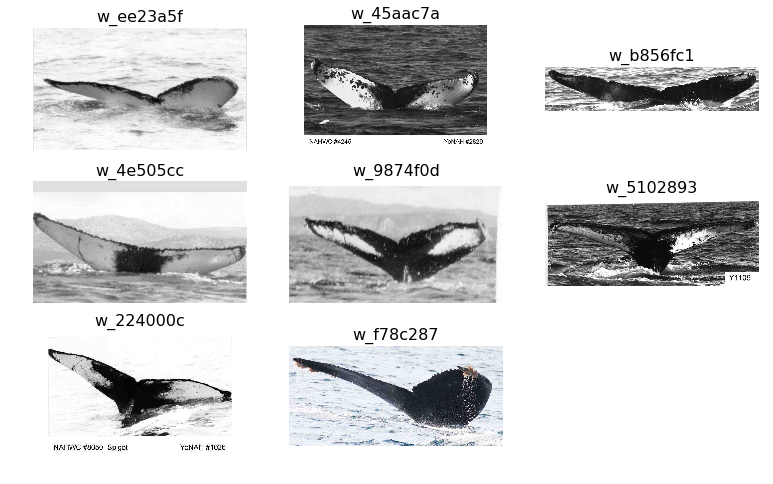

In [84]:
one_image_ids = train_df['Id'].value_counts().tail(8).keys()
one_image_filenames = []
labels = []
for i in one_image_ids:
    one_image_filenames.extend(list(train_df[train_df['Id'] == i]['Image']))
    labels.append(i)
    
plot_images_for_filenames(one_image_filenames, labels, rows=3)

From these small sample sizes, it seems like > 50% of images are black and white, suggesting that a good initial augementation might be to just convert colour images to greyscale and add to the training set. Let's confirm that by looking at a sample of the images.

In [ ]:
def is_grey_scale(img_path):
    """Thanks to https://stackoverflow.com/questions/23660929/how-to-check-whether-a-jpeg-image-is-color-or-gray-scale-using-only-python-stdli"""
    im = Image.open(img_path).convert('RGB')
    w,h = im.size
    for i in range(w):
        for j in range(h):
            r,g,b = im.getpixel((i,j))
            if r != g != b: return False
    return True

In [ ]:
is_grey = [is_grey_scale(INPUT_DIR+str(i)) for i in train_df['Image'].sample(frac=0.1)]
grey_perc = round(sum([i for i in is_grey]) / len([i for i in is_grey]) * 100, 2)
print(' of grey images: '+grey_perc)

It might also be worth capturing the size of the images so we can get a sense of what we're dealing with.

In [ ]:
img_sizes = Counter([Image.open('{INPUT_DIR}/train/{i}').size for i in train_df['Image']])

size, freq = zip(*Counter({i: v for i, v in img_sizes.items() if v > 1}).most_common(20))

plt.figure(figsize=(10, 6))

plt.bar(range(len(freq)), list(freq), align='center')
plt.xticks(range(len(size)), list(size), rotation=70)
plt.title("Image size frequencies (where freq > 1)")

plt.show()

## Data Augmentation

In [117]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img(INPUT_DIR+'/ff38054f.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
print('Image size: '+str(x.shape))
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='../data/dataAugment', save_prefix='whale', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

Image size: (748, 1050, 3)


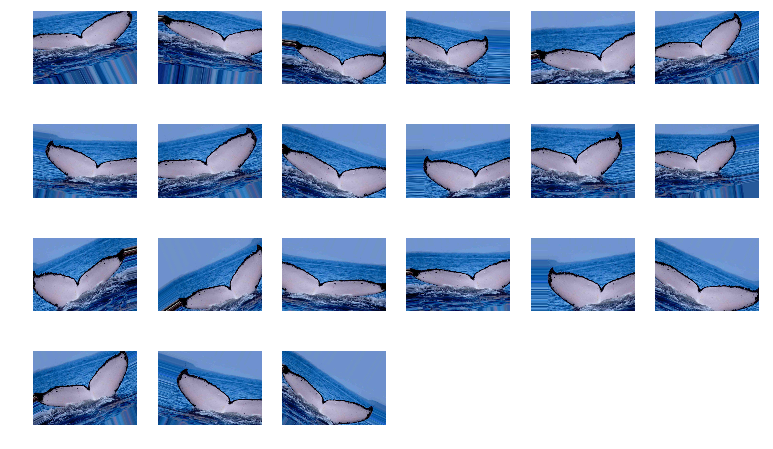

In [125]:
images = os.listdir('../data/dataAugment')

plot_images_in_dir(images, None, '../data/dataAugment', rows=4)

Now it is time to look at the image sizes

In [177]:
image_dir='../data/train_images/train'
train_images = os.listdir(image_dir)
height = []
width = []
print('Total number of images: '+str(len(train_images)))
img = load_img(image_dir+'/'+train_images[1])  # this is a PIL image
x = img_to_array(img) 
print(x.shape)
for image in train_images:
    img = load_img(image_dir+'/'+image)  # this is a PIL image
    x = img_to_array(img)
    height.append(x.shape[0])
    width.append(x.shape[1])
     

Total number of images: 9850
(450, 1050, 3)


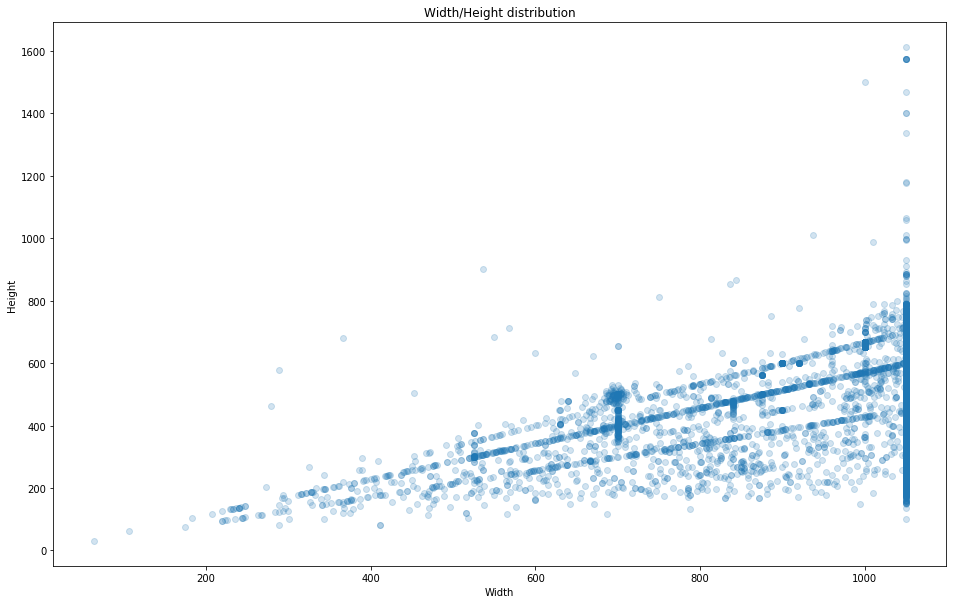

In [178]:
plt.figure(figsize=(16, 10))
plt.title('Width/Height distribution')
plt.xlabel('Width')
plt.ylabel('Height')
plt.scatter(width, height, alpha=.2)
plt.show()

### We are going to find out the average aspect ratio

The average aspect ratio is: 2.2621956


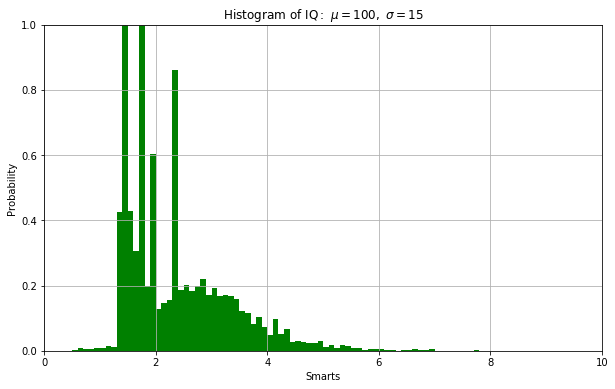

In [179]:
width = np.asarray(width, dtype=np.float32)
height = np.asarray(height, dtype=np.float32)
aspectratio = width/height
print('The average aspect ratio is: '+str(np.mean(aspectratio)))

plt.figure(figsize=(10, 6))

# the histogram of the data
n, bins, patches = plt.hist(aspectratio, 100, normed=1, facecolor='green')

# add a 'best fit' line
#y = mlab.normpdf( bins, mu, sigma)
#l = plt.plot(bins, y, 'r--', linewidth=1)

plt.xlabel('Smarts')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=100,\ \sigma=15$')
plt.axis([0, 10, 0, 1])
plt.grid(True)

plt.show()

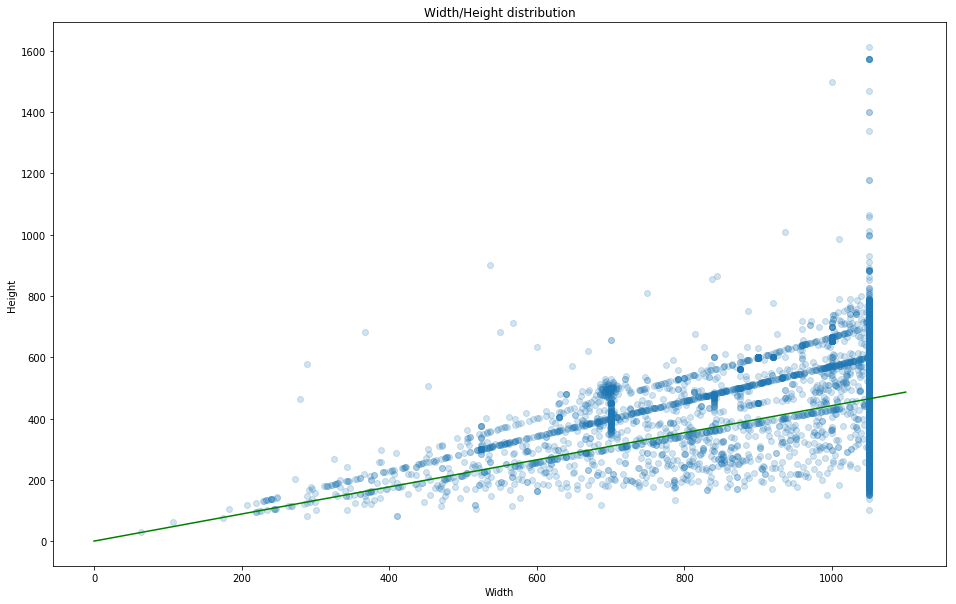

In [180]:
plt.figure(figsize=(16, 10))
plt.title('Width/Height distribution')
plt.xlabel('Width')
plt.ylabel('Height')
plt.scatter(width, height, alpha=.2)
line_x_range = (0, 1100)
plt.plot(line_x_range, [ a * 1/np.mean(aspectratio) for a in line_x_range], "g", alpha=1)
plt.show()

In [182]:
def compute_pairs(n):
    pairs = 0
    for pair in range(1,n-1):
        pairs += pair
        
    return pairs

pictures_in_class = 15
print('For '+str(pictures_in_class)+' pictures in class there are '+str(compute_pairs(pictures_in_class))+' pairs.')

For 15 pictures in class there are 91 pairs.
